In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
import optuna

In [46]:
df = pd.read_csv('winequality-red.csv')

In [47]:
df.quality.value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

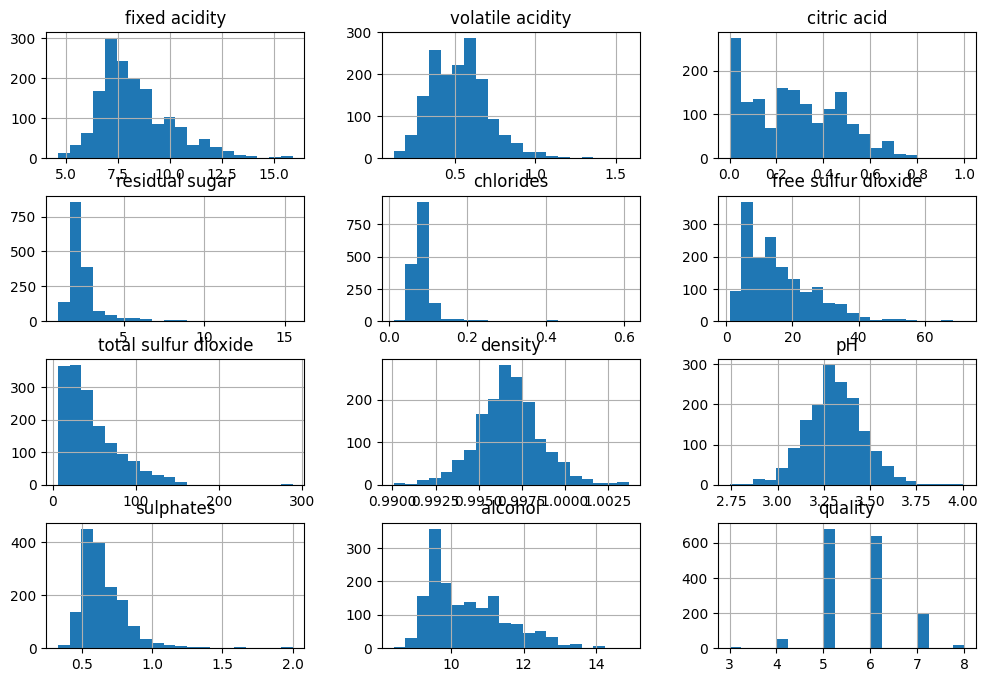

In [48]:
df.hist(figsize=(12, 8), bins=20)
plt.show()

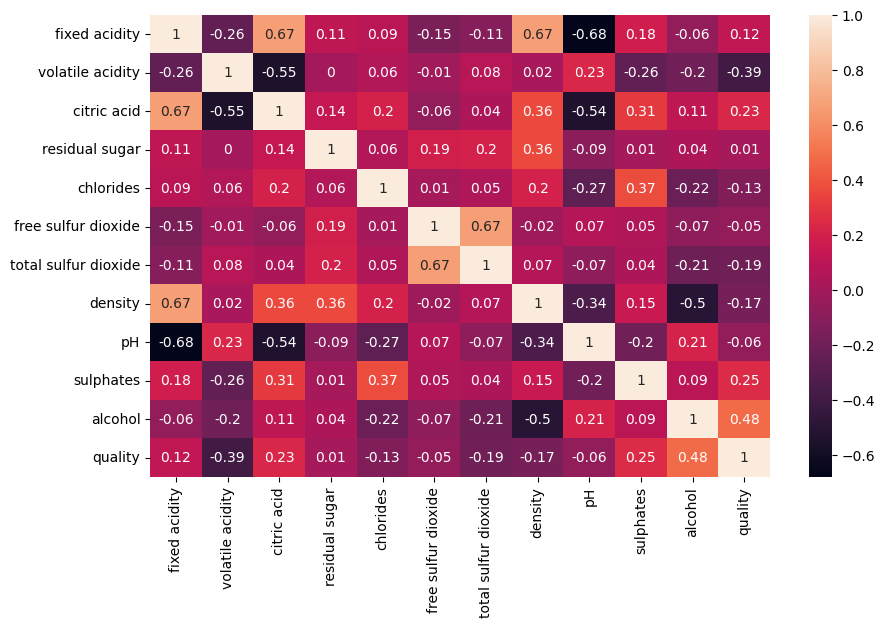

In [49]:
corr = df.corr()

f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(round(corr, 2), annot=True)#, cmap='')

plt.show()

In [50]:
X = df.drop(columns='quality')
y = df.quality.apply(lambda x: 0 if x <= 5 else 1)

In [51]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.25, random_state=42)

In [52]:
X_train_val.shape, X_train.shape, X_val.shape, X_test.shape

((1279, 11), (959, 11), (320, 11), (320, 11))

In [53]:

#Exemplu random
param_grid = { 
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    #'min_samples_split': [1, 2, 5, 10, 20, 50]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=4 #numarul de antrenamente paralel(depinde de nuclee la pc)
)
grid_search.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [54]:
grid_search.best_params_

{'max_depth': 30, 'n_estimators': 200}

In [55]:
grid_search.best_score_

np.float64(0.8204866938550038)

In [56]:
grid_search.cv_results_

{'mean_fit_time': array([0.83973699, 1.55593491, 0.71440034, 1.51392846, 0.92265401,
        1.61991053, 0.76884604, 1.45397735]),
 'std_fit_time': array([0.04208503, 0.01674361, 0.03576693, 0.09366651, 0.08448034,
        0.02633501, 0.0334529 , 0.09488744]),
 'mean_score_time': array([0.02787147, 0.04923058, 0.03048081, 0.05234065, 0.03389091,
        0.04742565, 0.0275744 , 0.04591951]),
 'std_score_time': array([0.00295245, 0.00530932, 0.00299809, 0.00943726, 0.00629894,
        0.00221032, 0.0039203 , 0.01143552]),
 'param_max_depth': masked_array(data=[None, None, 10, 10, 20, 20, 30, 30],
              mask=[False, False, False, False, False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200, 100, 200, 100, 200, 100, 200],
              mask=[False, False, False, False, False, False, False, False],
        fill_value=999999),
 'params': [{'max_depth': None, 'n_estimators': 100},
  {'max_depth': No

In [57]:
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist, 
    n_iter=50, 
    cv=5,
    scoring='f1',
    n_jobs=4,
    verbose=1
)

random_search.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
random_search.best_params_

{'max_depth': 30, 'min_samples_split': 3, 'n_estimators': 289}

In [ ]:
random_search.best_score_

np.float64(0.825716991515266)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ------------------------------ --------- 1.6/2.1 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 7.8 MB/s eta 0:00:00


In [ ]:
def objective(trail):
    n_estimators = trail.suggest_int('n_estimators', 50, 300)
    max_depth = trail.suggest_int('max_depth', 2, 32)
    min_samples_split = trail.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trail.suggest_int('min_samples_leaf', 1, 10)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    score = cross_val_score(rf, X_train_val, y_train_val, cv=5, scoring='f1').mean()

    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-08 19:55:49,187] A new study created in memory with name: no-name-f48b4ce4-9645-4914-af3b-ad84e2ebfb22
[I 2024-11-08 19:55:52,210] Trial 0 finished with value: 0.7842271425714423 and parameters: {'n_estimators': 158, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7842271425714423.
[I 2024-11-08 19:55:54,021] Trial 1 finished with value: 0.7729396012505898 and parameters: {'n_estimators': 164, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7842271425714423.
[I 2024-11-08 19:55:54,818] Trial 2 finished with value: 0.7813769674904201 and parameters: {'n_estimators': 62, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7842271425714423.
[I 2024-11-08 19:55:59,150] Trial 3 finished with value: 0.8027571392800883 and parameters: {'n_estimators': 260, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value:

In [ ]:
study.best_params

{'n_estimators': 272,
 'max_depth': 19,
 'min_samples_split': 4,
 'min_samples_leaf': 1}

In [60]:
params = {
    'n_estimators': 272,
    'max_depth': 19,
    'min_samples_split': 4,
    'min_samples_leaf': 1
}

rf2 = RandomForestClassifier(**params)

rf2.fit(X_train, y_train)
y_pred_val = rf2.predict(X_val)

In [61]:
f1_score(y_val, y_pred_val)

np.float64(0.8103448275862069)